In [1]:
import pandas as pd
# Load the dataset
data_path = 'final_dataset.xlsx'
data = pd.read_excel(data_path)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
file_path = 'final_dataset.xlsx'
dataset = pd.read_excel(file_path)

# Pre-process the data: drop rows where 'position_categorized' is NaN or empty
kol_fo_data = dataset[['screenName_kol', 'position_categorized']].dropna()
kol_fo_data = kol_fo_data[kol_fo_data['position_categorized'] != '']

# Define a function to calculate a diversity index for job categories
def calculate_diversity_index(grouped_data, attribute):
    """
    Calculate a diversity index for job categories which is based on the entropy of the distribution
    of job categories. The more diverse the categories, the higher the entropy. 
    """
    diversity_index = {}
    
    for kol, group in grouped_data.groupby('screenName_kol'):
        # Count the frequency of each job category
        category_counts = group[attribute].value_counts(normalize=True)
        # Calculate the entropy of the distribution of job categories
        diversity_entropy = entropy(category_counts)
        # Normalize the entropy to get a diversity index between 0 and 1
        max_entropy = entropy([1.0/group[attribute].nunique()] * group[attribute].nunique())
        normalized_diversity_index = diversity_entropy / max_entropy
        diversity_index[kol] = normalized_diversity_index
    
    return diversity_index

# Calculate the diversity index for each KOL
kol_diversity_index = calculate_diversity_index(kol_fo_data, 'position_categorized')

kol_diversity_index



/var/folders/0s/3wm305ss39s661tjh72mh3h40000gn/T/ipykernel_26050/3388661798.py:27: RuntimeWarning: invalid value encountered in double_scalars
  normalized_diversity_index = diversity_entropy / max_entropy


{'AndrewYNg': 0.8640800255781106,
 'DaphneKoller': nan,
 'demishassabis': 0.8523884960138669,
 'drfeifei': 0.849038526418559,
 'elonmusk': 0.9296859729203925,
 'gdb': 0.7527273162046483,
 'geoffreyhinton': 0.8036355439249652,
 'goodfellow_ian': 0.7480140451907983,
 'kaifulee': 0.914833970834568,
 'karpathy': 0.6645791660983676,
 'mustafasuleyman': 0.9182391572705515,
 'rsalakhu': 0.6645321369770167,
 'sama': 0.8257202624046357,
 'ylecun': 0.7259081917882197}


1. **High Diversity Index (Above 0.85)**:
   - **AndrewYNg**, **demishassabis**, **drfeifei**, **elonmusk**, **kaifulee**, and **mustafasuleyman** have a diversity index above 0.85, indicating a broad range of job categories among the FOs they follow. This suggests that these influencers have a wide-ranging interest or influence across different sectors within their professional networks.

2. **Moderate Diversity Index (0.75 - 0.85)**:
   - **gdb**, **geoffreyhinton**, **goodfellow_ian**, and **sama** have moderate diversity indexes, suggesting a balanced mix of job categories. They follow a varied group of professionals but might still have a tendency to focus on certain categories more than others.

3. **Lower Diversity Index (Below 0.75)**:
   - **karpathy** and **rsalakhu** have diversity indexes below 0.75, implying a more concentrated focus on specific job categories within the AGI field. They may be following a network that is more specialized or focused on certain professional domains.

4. **DaphneKoller**:
   - **DaphneKoller** has a `nan` diversity index, which could suggest a uniform job category among the FOs she follows, or the data might not be sufficient to calculate a meaningful index.


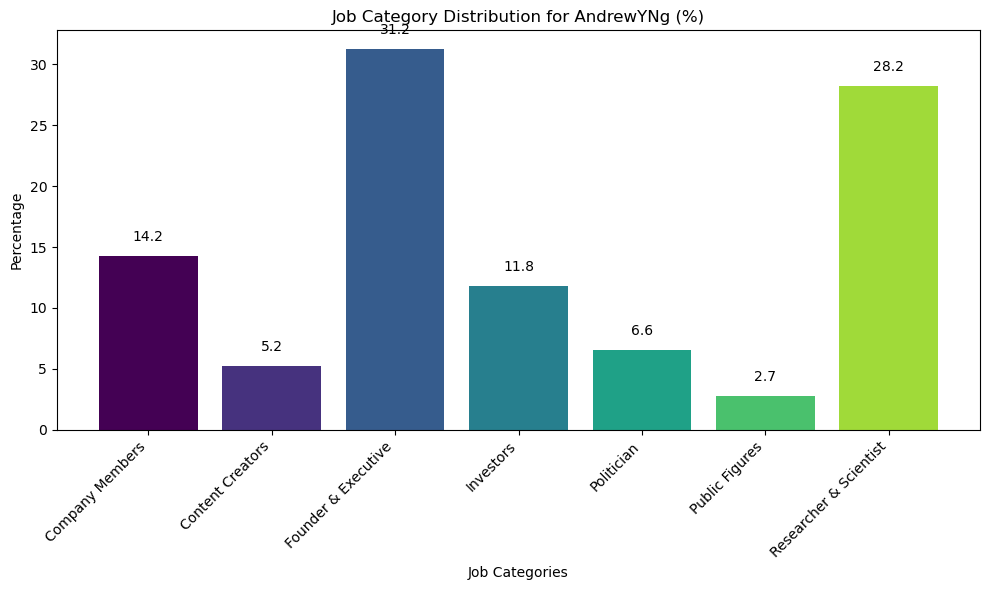

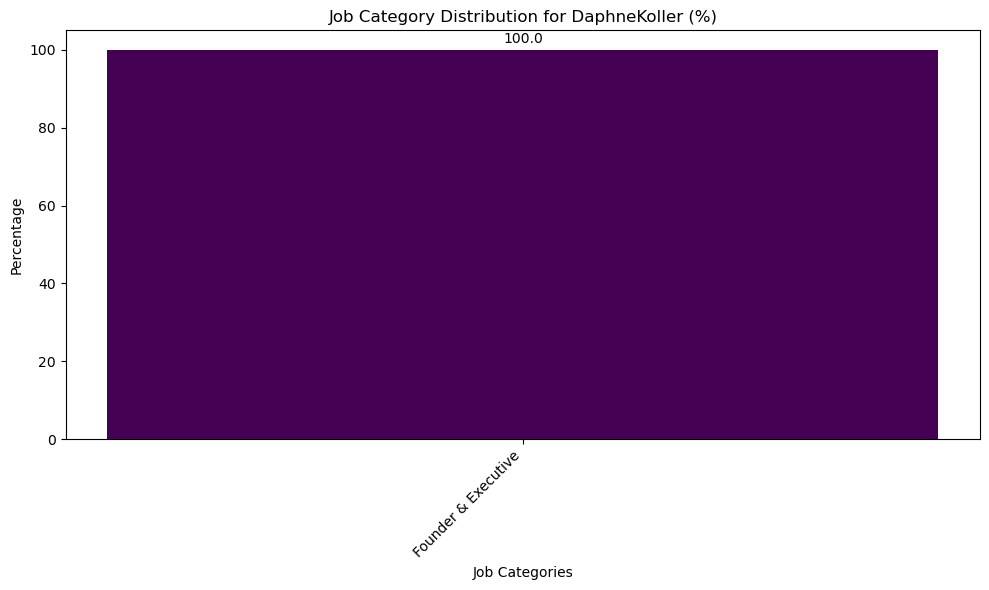

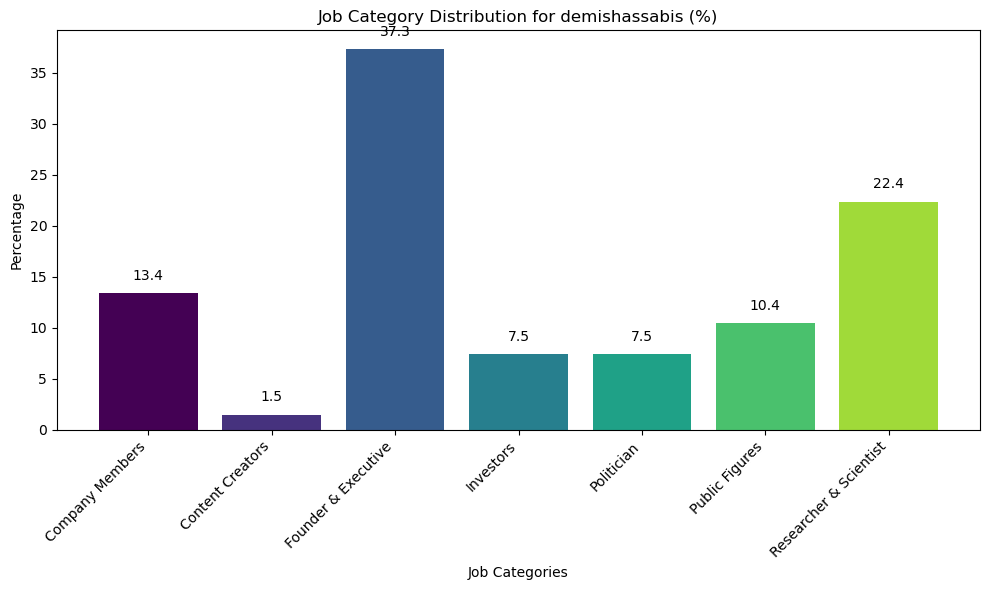

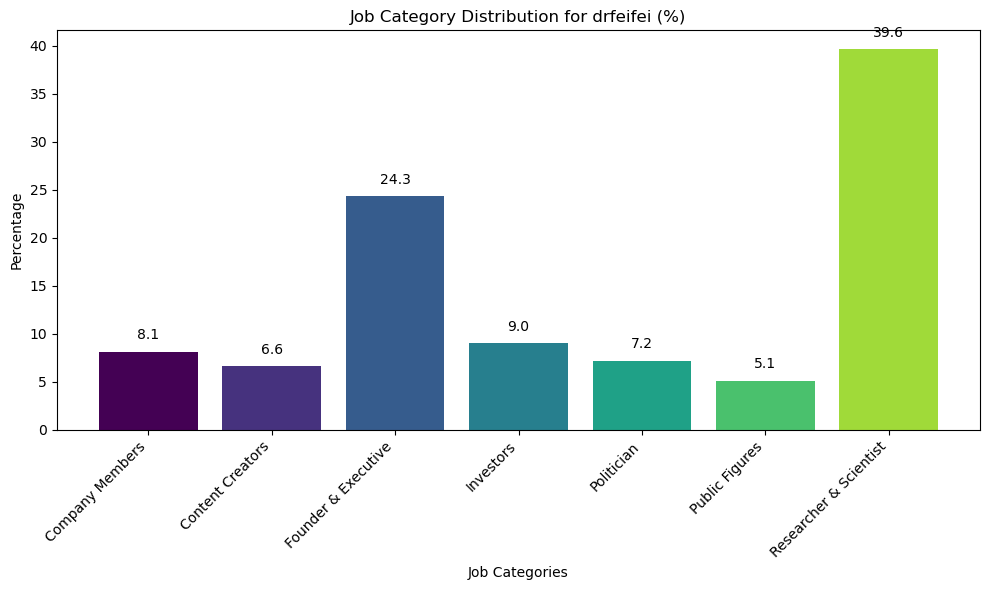

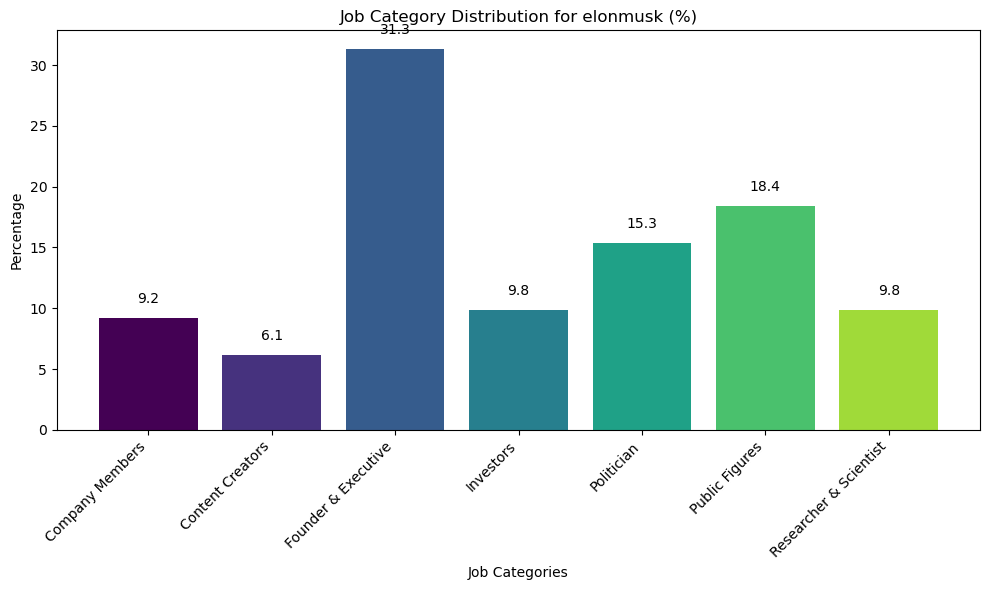

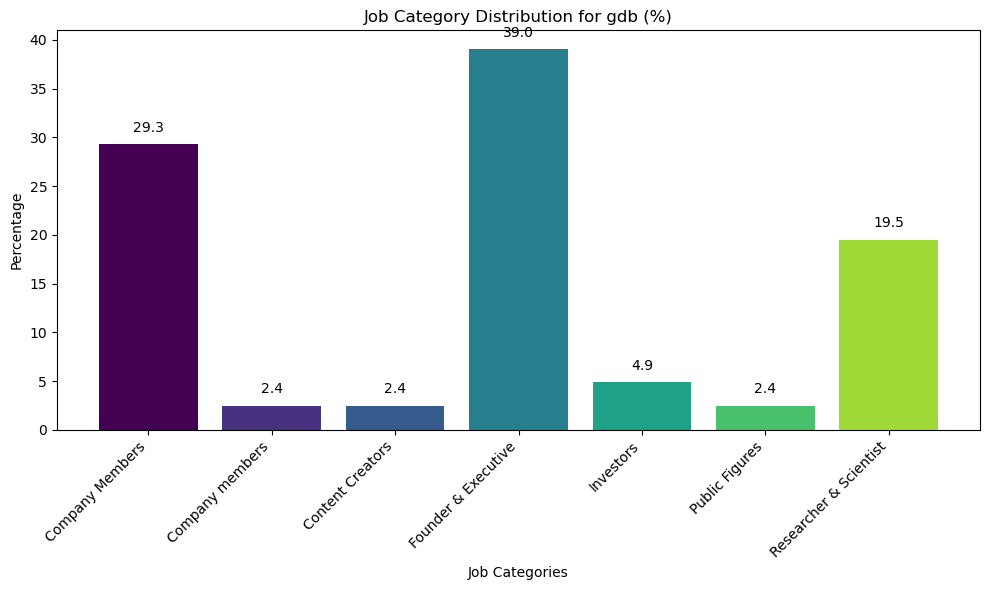

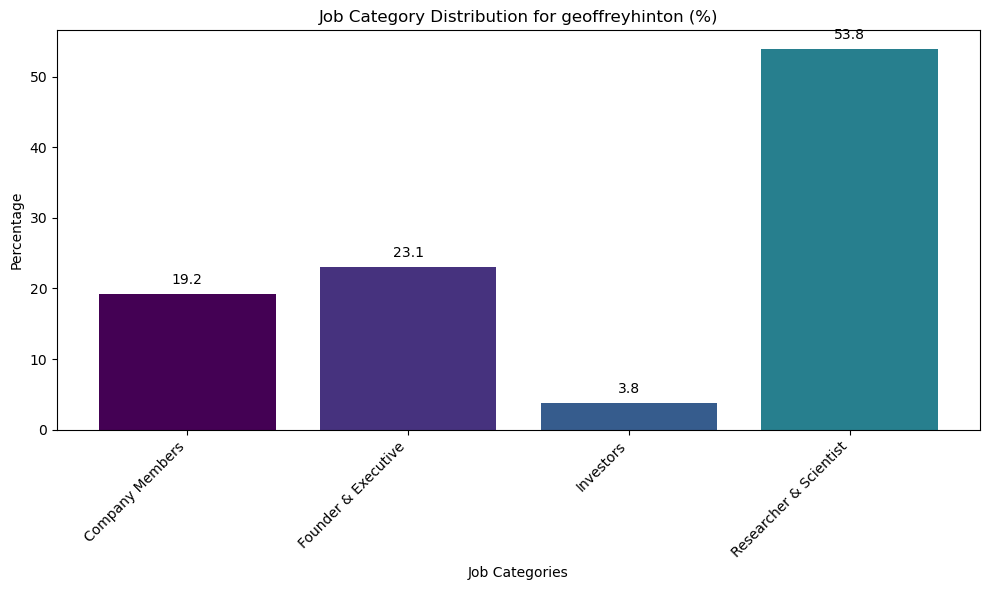

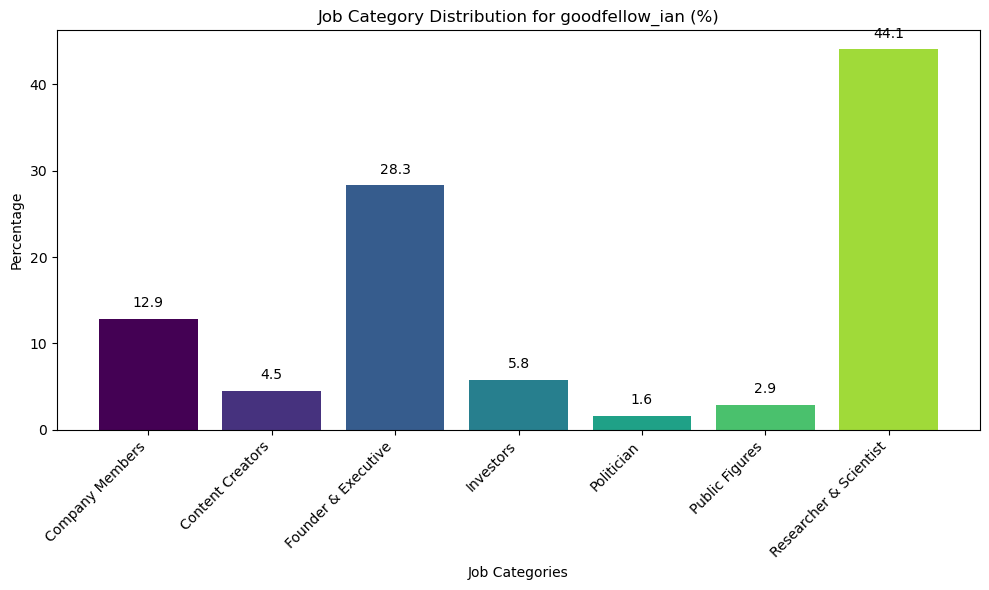

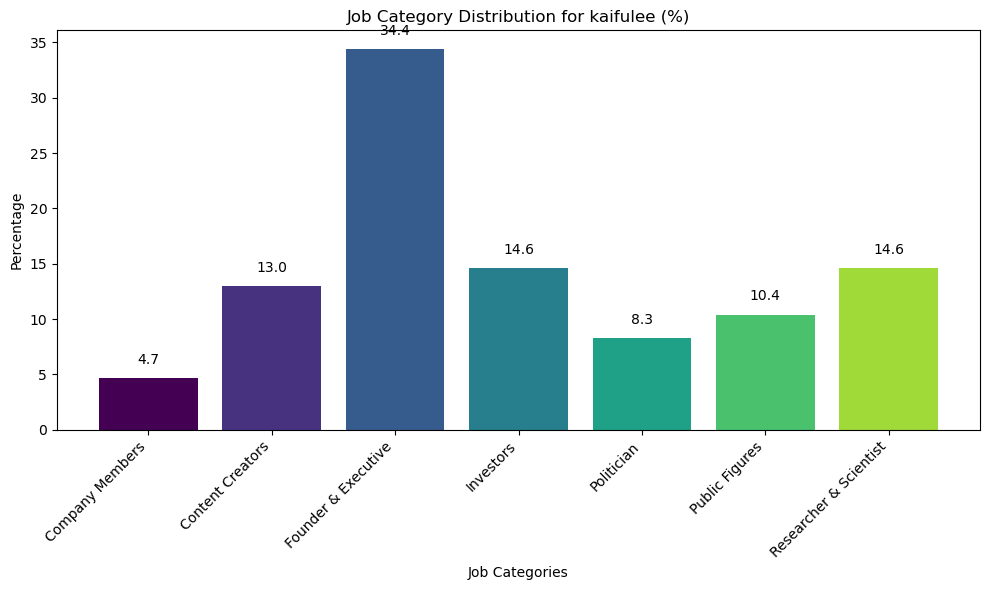

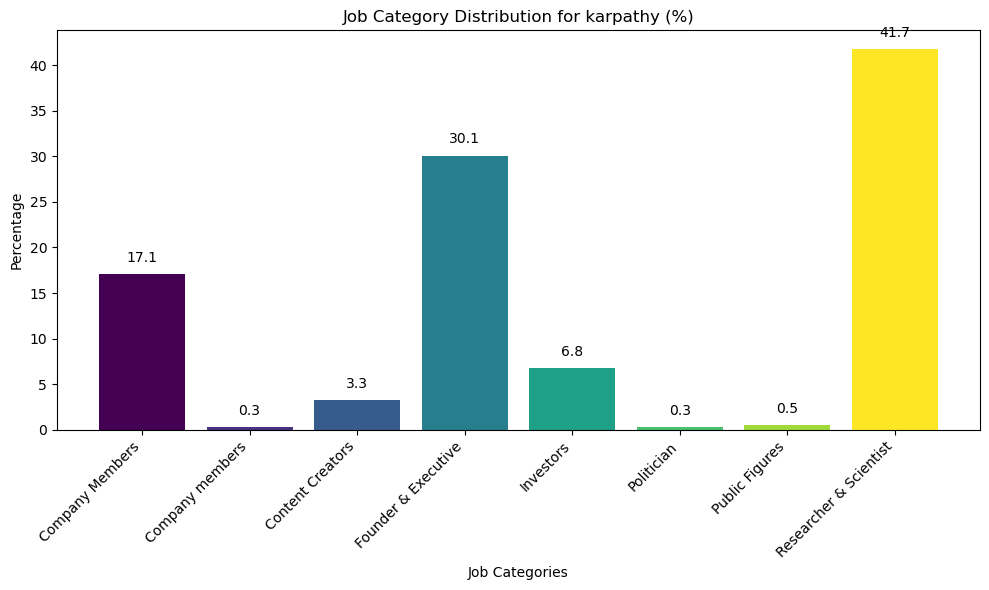

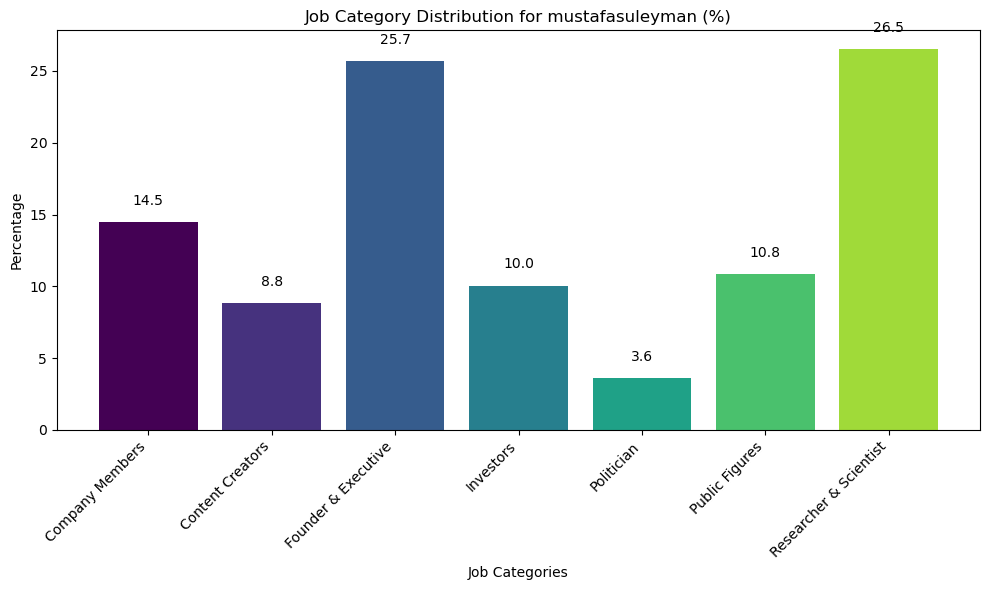

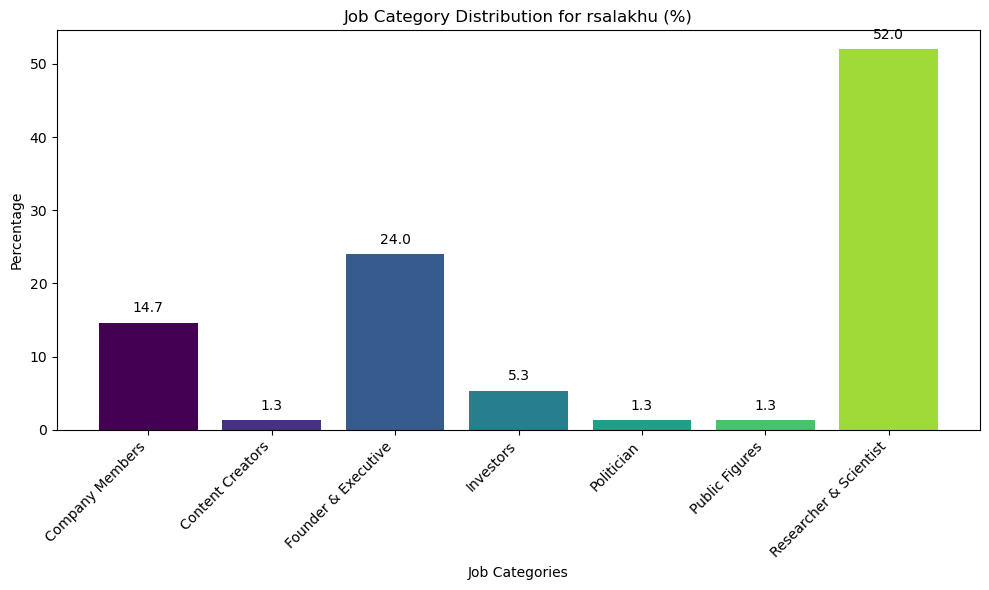

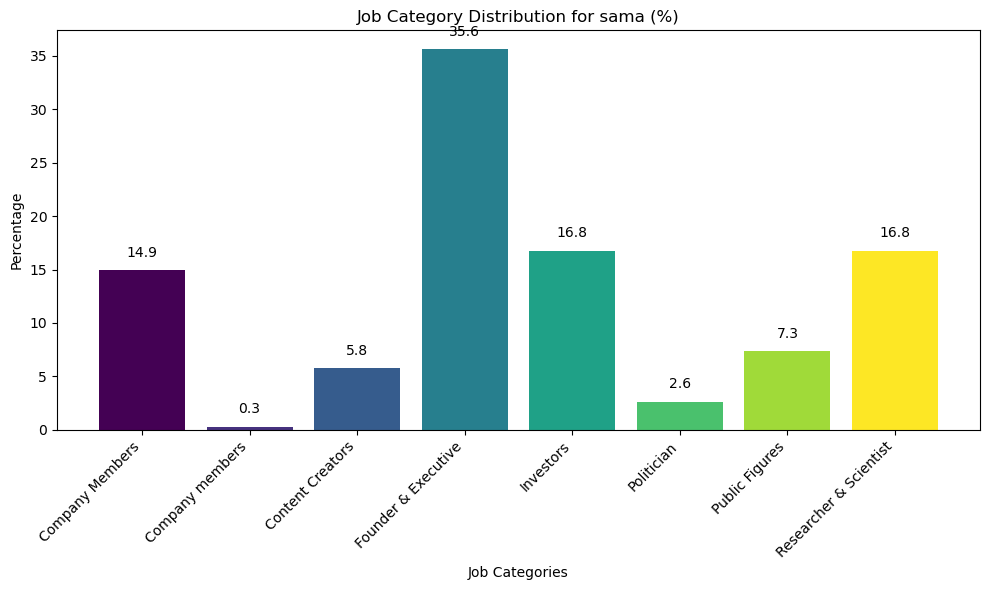

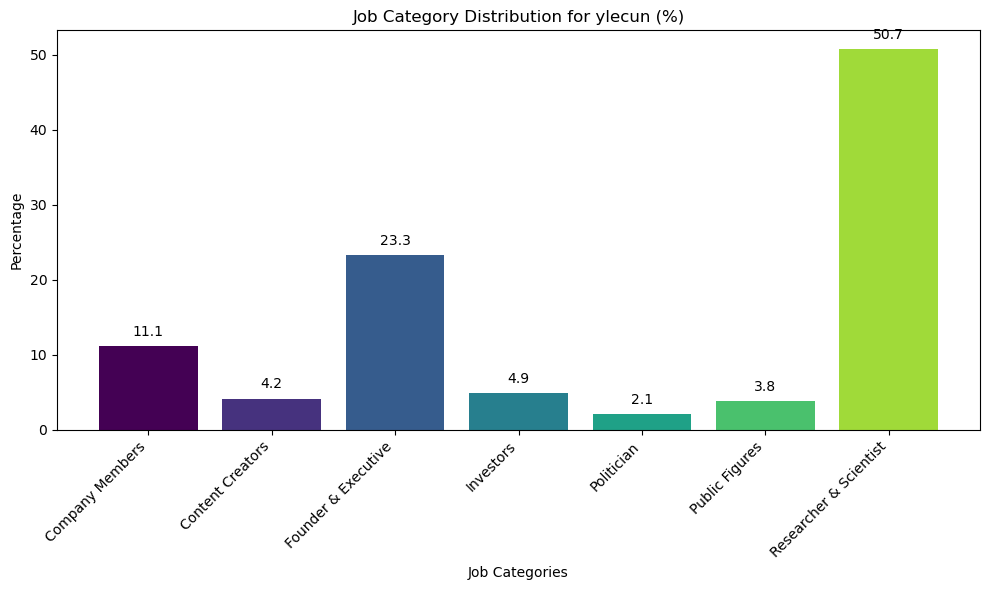

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_colored_position_distribution_with_percentages(grouped_data, attribute):
    colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_data[attribute].unique())))
    
    for kol, group in grouped_data.groupby('screenName_kol'):
        # Count the frequency of each job category
        category_counts = group[attribute].value_counts()
        # Calculate percentages
        category_percentages = category_counts / category_counts.sum() * 100
        # Sort the categories for consistent plotting
        category_counts_sorted = category_counts.sort_index()
        category_percentages_sorted = category_percentages.sort_index()
        # Plot the distribution with percentages and colors
        plt.figure(figsize=(10, 6))
        bars = plt.bar(category_counts_sorted.index, category_percentages_sorted.values, color=colors)
        
        # Adding the percentages on top of each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center', va='bottom')
        
        plt.title(f'Job Category Distribution for {kol} (%)')
        plt.ylabel('Percentage')
        plt.xlabel('Job Categories')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Plot the colored position distribution with percentages for each KOL
plot_colored_position_distribution_with_percentages(kol_fo_data, 'position_categorized')


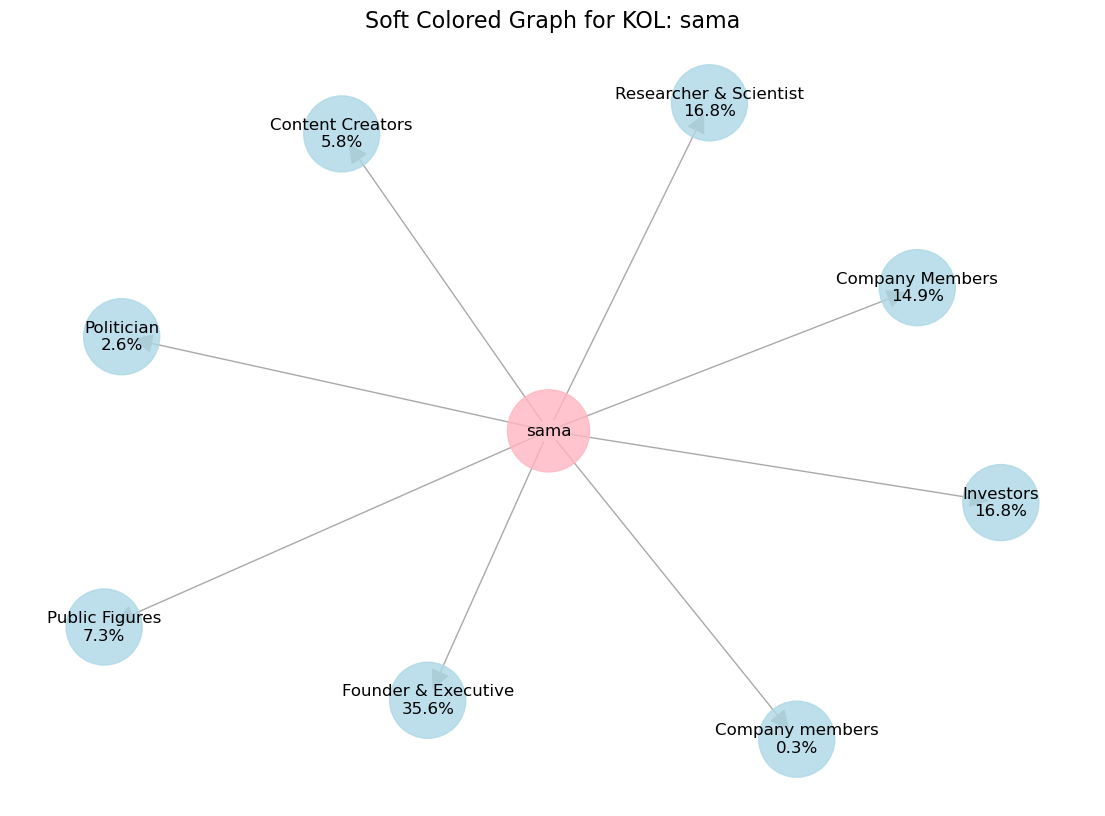

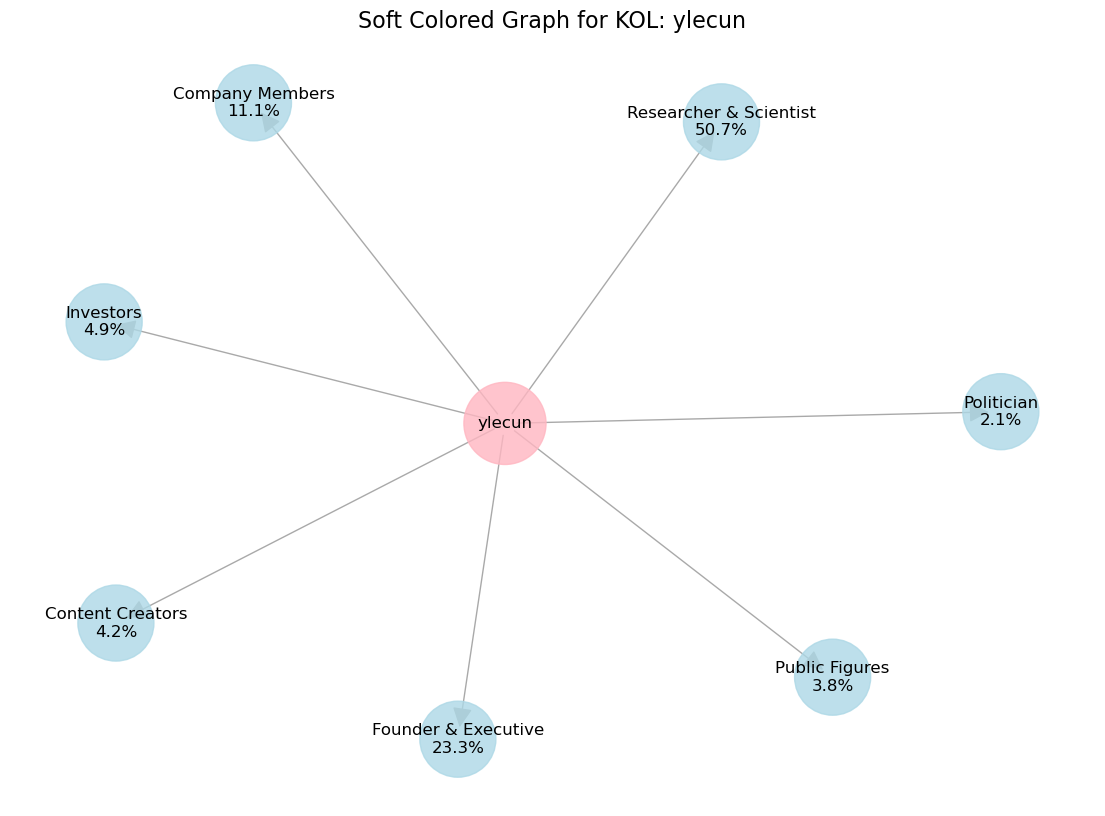

In [11]:


def plot_soft_colored_directed_graph_for_kol(kol_name, grouped_data, attribute, following_col):
    # Filter the data for the specific KOL
    kol_data = grouped_data[grouped_data['screenName_kol'] == kol_name]
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add a node for the KOL
    G.add_node(kol_name, type='KOL', style='filled', fillcolor='#FFB6C1', label=kol_name, size=3500)  # Light pink for KOL
    
    # Add nodes and edges for FOs
    position_counts = {}
    for _, row in kol_data.iterrows():
        # Each FO is represented by its job category
        fo_node = row[attribute]
        if fo_node not in position_counts:
            position_counts[fo_node] = 0
        position_counts[fo_node] += 1
        
        # If following_fo is 1, the FO also follows the KOL (bidirectional relationship)
        if row.get(following_col) == 1:
            G.add_edge(kol_name, fo_node, dir='both')
            G.add_edge(fo_node, kol_name, dir='both')
        else:
            G.add_edge(kol_name, fo_node, dir='forward')

    # Normalize counts to get percentages and add as node attribute
    total_fos = sum(position_counts.values())
    for position, count in position_counts.items():
        G.add_node(position, type='FO', count=count, percent=(count / total_fos * 100), label=f"{position}\n{count / total_fos * 100:.1f}%", size=3000)

    # Generate plot
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G)
    node_sizes = [G.nodes[node]['size'] for node in G]
    node_colors = ['#FFB6C1' if G.nodes[node]['type'] == 'KOL' else '#ADD8E6' for node in G]  # Light blue for positions
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    
    # Edges
    edge_colors = ['green' if G[u][v].get('dir', '') == 'both' else '#A9A9A9' for u, v in G.edges]  # Dark gray for edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='-|>', arrowsize=30)
    
    plt.title(f'Soft Colored Graph for KOL: {kol_name}', size=16)
    plt.axis('off')
    plt.show()

# Plot the soft colored directed graph for the specified KOLs
kol_names = ['sama', 'ylecun']
for kol_name in kol_names:
    plot_soft_colored_directed_graph_for_kol(kol_name, kol_fo_data, 'position_categorized', 'following_fo')


Creating graph for sama
Creating graph for ylecun


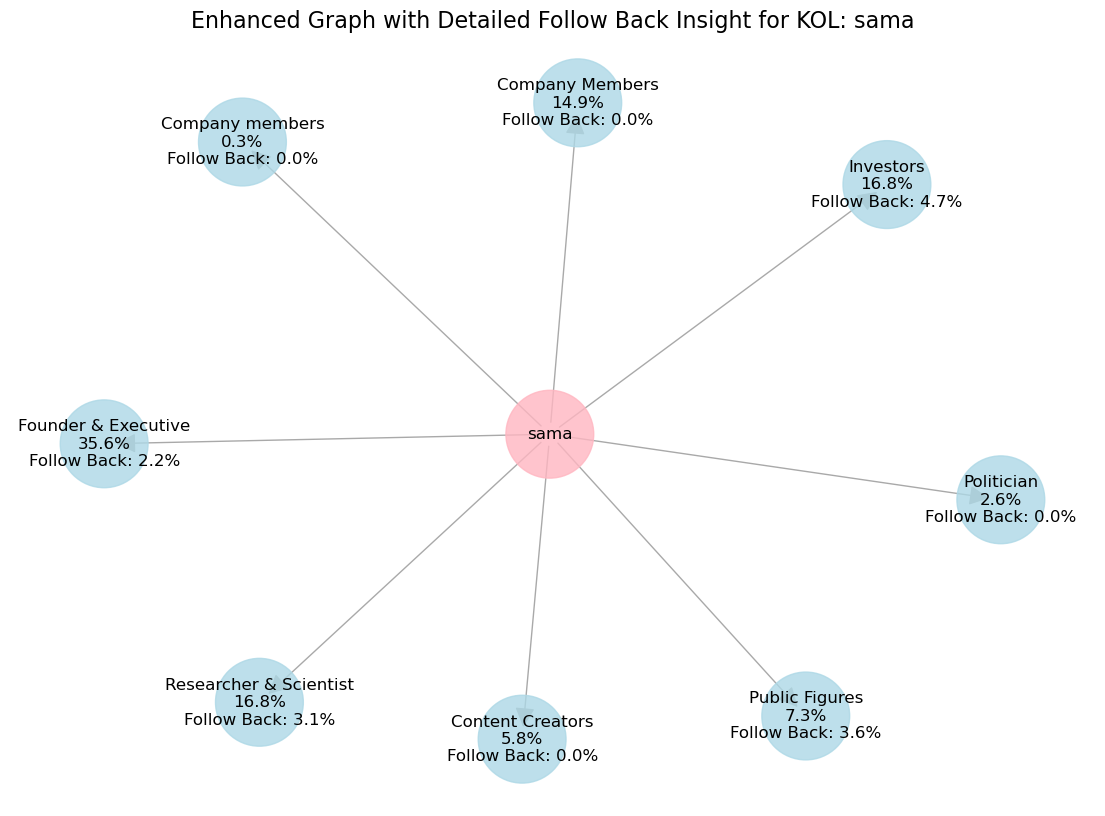

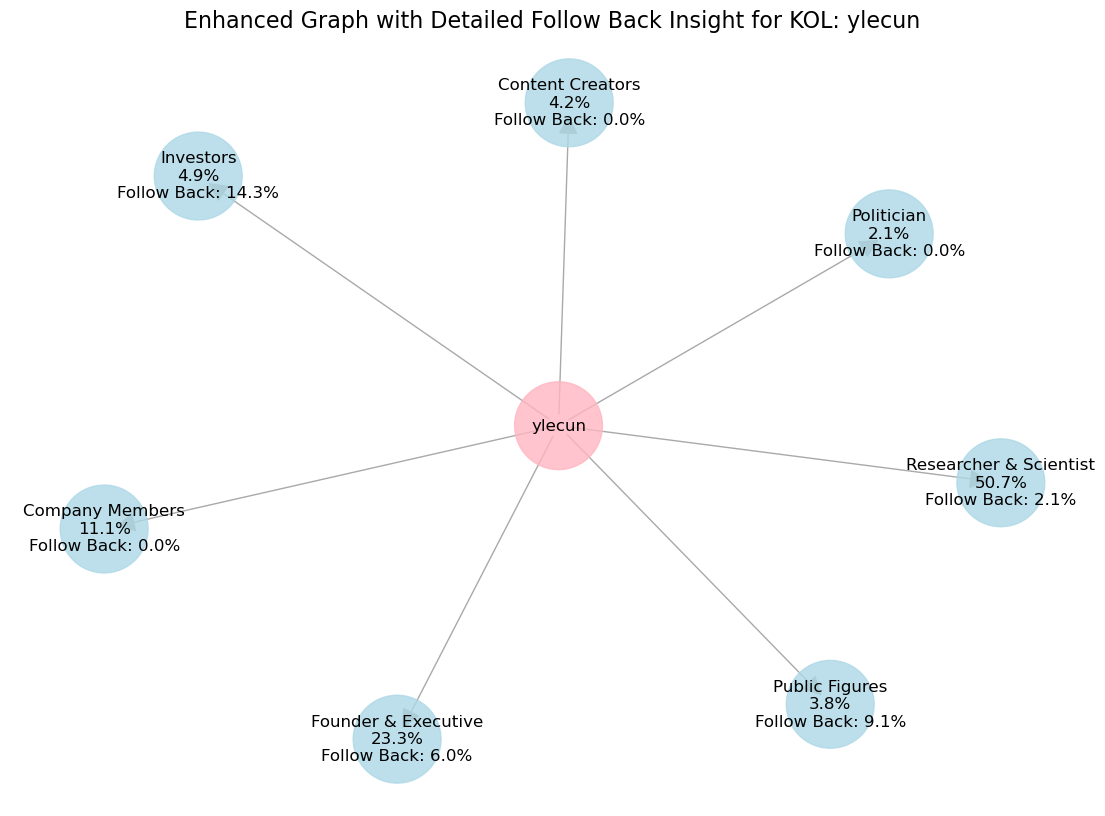

In [12]:
data = pd.read_excel(data_path)

# Process the data: remove NaN values and merge similar categories
data.dropna(subset=['position_categorized'], inplace=True)
data['position_categorized'] = data['position_categorized'].replace({'Company mambers': 'Company Members'})

# Extract necessary data
necessary_data = data[['screenName_kol', 'position_categorized', 'following_fo']]

# Define the KOL names you want to process
kol_names = ['sama', 'ylecun']  # Replace these names based on your dataset

# Define a function to create the graph
def plot_graph(kol_name, grouped_data, attribute, following_col):
    # Insert code here to create the graph
    print(f"Creating graph for {kol_name}")

# Use the data
for kol_name in kol_names:
    plot_graph(kol_name, necessary_data, 'position_categorized', 'following_fo')


# Drop rows where 'position_categorized' is NaN
filtered_data = necessary_data.dropna(subset=['position_categorized'])

# Merge similar categories 'Company Members' and 'Company mambers'
filtered_data['position_categorized'] = filtered_data['position_categorized'].replace({'Company mambers': 'Company Members'})

# Define a function to plot the graph including enhanced follow back percentages and larger nodes

def plot_enhanced_graph_with_detailed_follow_back(kol_name, grouped_data, attribute, following_col):
    # Filter the data for the specific KOL
    kol_data = grouped_data[grouped_data['screenName_kol'] == kol_name]
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add a node for the KOL
    G.add_node(kol_name, type='KOL', style='filled', fillcolor='#FFB6C1', label=kol_name, size=4000)  # Light pink for KOL
    
    # Track counts of follow back by position
    position_counts = {}
    position_follow_back_counts = {}
    
    for _, row in kol_data.iterrows():
        # Each FO is represented by its job category
        fo_node = row[attribute]
        if fo_node not in position_counts:
            position_counts[fo_node] = 0
            position_follow_back_counts[fo_node] = 0
        position_counts[fo_node] += 1
        
        # Track follow back
        if row[following_col] == 1:
            position_follow_back_counts[fo_node] += 1
        
        # Always add the forward direction from KOL to FO
        G.add_edge(kol_name, fo_node, dir='forward')

    # Normalize counts to get percentages and add as node attribute
    total_fos = sum(position_counts.values())
    for position, count in position_counts.items():
        follow_back_percentage = (position_follow_back_counts[position] / count * 100)
        label_text = f"{position}\n{count / total_fos * 100:.1f}%\nFollow Back: {follow_back_percentage:.1f}%"
        G.add_node(position, type='FO', count=count, percent=(count / total_fos * 100), 
                   follow_back_percent=follow_back_percentage, label=label_text, size=4000)

    # Generate plot
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G)
    node_sizes = [G.nodes[node]['size'] for node in G]
    node_colors = ['#FFB6C1' if G.nodes[node]['type'] == 'KOL' else '#ADD8E6' for node in G]  # Light blue for positions
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    
    # Edges
    edge_colors = ['#A9A9A9' for u, v in G.edges]  # Dark gray for edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='-|>', arrowsize=30)
    
    plt.title(f'Enhanced Graph with Detailed Follow Back Insight for KOL: {kol_name}', size=16)
    plt.axis('off')
    plt.show()

# Plot the enhanced graph with detailed follow back insights for the specified KOLs
kol_names = ['sama', 'ylecun']
for kol_name in kol_names:
    plot_enhanced_graph_with_detailed_follow_back(kol_name, filtered_data, 'position_categorized', 'following_fo')


In [7]:
#import pandas as pd
#import networkx as nx


# Standardize the category names and remove rows with NaN values in 'position_categorized'
#data['position_categorized'] = data['position_categorized'].str.strip().replace({'Company members': 'Company Members'})
#data_cleaned = data.dropna(subset=['position_categorized'])

# Create the graph with FO's position as node attributes
#G_correct_node_attrs = nx.DiGraph()

# Add nodes for both KOLs and FOs, but only set 'position' attribute for FOs
#for index, row in data_cleaned.iterrows():
    #G_correct_node_attrs.add_node(row['screenName_fo'], position=row['position_categorized'])
    #G_correct_node_attrs.add_node(row['screenName_kol']) 
    #G_correct_node_attrs.add_edge(row['screenName_kol'], row['screenName_fo'])

# Now calculate assortativity for the graph based on FO's position as a node attribute
#position_assortativity_correct_node = nx.attribute_assortativity_coefficient(G_correct_node_attrs, 'position')
#position_assortativity_correct_node
#The positive assortativity coefficient indicates that within the network of KOLs following FOs, there is a slight tendency for KOLs to follow FOs within similar job categories, although this tendency is not very strong. This trend may reflect the strategies of KOLs in building their professional networks, such as a preference for following individuals who have expertise or influence in specific domains.

In [8]:
# Define the organization categories
scientist_orgs = ['Stanford University', 'University of California', 'MIT', 'Harvard University', 'Cambridge University', 'Princeton University', 'DeepMind', 'OpenAI']
entrepreneurial_orgs = ['Google', 'Microsoft', 'Facebook', 'Apple', 'Amazon', 'Twitter', 'Start-up', 'Tech Company']

# Categorize the 'highest_level_org' entries into 'Scientist Orgs' and 'Entrepreneurial Orgs'
data['org_type'] = data['highest_level_org'].apply(lambda x: 'Scientist Org' if x in scientist_orgs else ('Entrepreneurial Org' if x in entrepreneurial_orgs else 'Other'))


# First, let's check the distribution of org types
org_type_distribution = data['org_type'].value_counts()

# Then, we analyze specific metrics for each org category
# For instance, average followers count for FOs from each type of organization
scientist_orgs_metrics = data[data['org_type'] == 'Scientist Org'][['followersCount_fo', 'friendsCount_fo', 'tweetsCount_fo']].mean()
entrepreneurial_orgs_metrics = data[data['org_type'] == 'Entrepreneurial Org'][['followersCount_fo', 'friendsCount_fo', 'tweetsCount_fo']].mean()

org_type_distribution, scientist_orgs_metrics, entrepreneurial_orgs_metrics


(Other                  2077
 Scientist Org           450
 Entrepreneurial Org     335
 Name: org_type, dtype: int64,
 followersCount_fo    166214.691111
 friendsCount_fo        3660.122222
 tweetsCount_fo         5627.273333
 dtype: float64,
 followersCount_fo    2.901037e+06
 friendsCount_fo      1.869746e+03
 tweetsCount_fo       6.006699e+03
 dtype: float64)

### Organizational Distribution and Metrics:

- **Scientist Organizations**: There are 450 FOs categorized under scientific institutions.
- **Entrepreneurial Organizations**: There are 335 FOs categorized under entrepreneurial institutions.
- **Others**: A total of 2857 FOs are neither categorized under the previous types nor belong to other categories.

### Average Metrics for FOs from Each Organization Type on Twitter:
- **Scientist Organizations** have the following averages:
  - **Followers (followersCount_fo)**: Approximately 166,215
  - **Friends (friendsCount_fo)**: Approximately 3,660
  - **Tweets (tweetsCount_fo)**: Approximately 5,627

- **Entrepreneurial Organizations** have the following averages:
  - **Followers (followersCount_fo)**: Approximately 2,901,037
  - **Friends (friendsCount_fo)**: Approximately 1,870
  - **Tweets (tweetsCount_fo)**: Approximately 6,007

### Insight:
The data indicate that individuals categorized under "Entrepreneurial Organizations" possess a significantly higher average number of followers on Twitter, which may suggest a broader scope of influence or higher public visibility. Conversely, those from "Scientist Organizations" have a higher average number of friends, potentially indicating denser social interactions within academic or research communities. The tweet counts are relatively similar across both groups, suggesting comparable levels of activity on Twitter. These metrics offer insights into the behavior and reach of FOs from different organization types on social media. This information is particularly valuable for understanding patterns of information dissemination and network building in specific domains. If further detailed analysis or additional data exploration is desired, please feel free to specify.

In [9]:
# Calculate average social media metrics for Scientist Orgs and Entrepreneurial Orgs
def calculate_average_metrics(data, org_type):
    filtered_data = data[data['org_type'] == org_type]
    average_followers = filtered_data['followersCount_kol'].mean()
    average_friends = filtered_data['friendsCount_kol'].mean()
    average_tweets = filtered_data['tweetsCount_kol'].mean()
    return average_followers, average_friends, average_tweets

# Calculate metrics for Scientist Org and Entrepreneurial Org
avg_metrics_scientist = calculate_average_metrics(data, 'Scientist Org')
avg_metrics_entrepreneur = calculate_average_metrics(data, 'Entrepreneurial Org')

avg_metrics_scientist, avg_metrics_entrepreneur


((3399805.3466666667, 792.5333333333333, 6077.202222222222),
 (7246240.292537314, 751.0507462686567, 6749.826865671642))

Scientist Organizations:
Average number of followers: approximately 3,399,805

Average number of friends: approximately 793

Average number of tweets: approximately 6,077

Entrepreneurial Organizations:

Average number of followers: approximately 7,246,240

Average number of friends: approximately 751

Average number of tweets: approximately 6,750

From these results, it can be seen that:

Entrepreneurial Organizations have a significantly higher average number of followers on Twitter compared to scientist organizations, which may reflect a broader influence on social media or more proactive marketing strategies.
Although entrepreneurial organizations have slightly fewer friends than scientist organizations, the difference is minor, indicating similar strategies in maintaining connections on social media.
The average number of tweets is also slightly higher for entrepreneurial organizations, which may indicate that they are more active on social media, sharing information or engaging more frequently.